In [5]:
!pip install -q python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 23.8 MB/s eta 0:00:0000:0100:01


In [41]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import time
from joblib import Parallel, delayed

# --- 1. FUNZIONI TEORICHE ---
def theoretical_S_chi(k_mean):
    if np.isclose(k_mean, 1.0): return 0.0, np.inf
    if k_mean < 1.0: return 0.0, 1.0 / (1.0 - k_mean)
    func = lambda x: x - 1 + np.exp(-k_mean * x)
    S = fsolve(func, x0=0.5)[0]
    chi = 1.0 / (1.0 - k_mean + k_mean * S)
    return S, chi

k_theory = np.linspace(0, 5, 1000)
S_theory, chi_theory = zip(*[theoretical_S_chi(k) for k in k_theory])

# --- 2. MOTORE C: IGRAPH ---
def simulate_single_graph(N, p):
    # igraph genera il grafo ER in C in modo estremamente ottimizzato
    G = ig.Graph.Erdos_Renyi(n=N, p=p, directed=False)
    
    # Calcola le componenti e ne restituisce le dimensioni direttamente
    sizes = G.connected_components().sizes()
    sizes.sort(reverse=True)
    
    if not sizes:
        return 0.0, 0.0
        
    S_val = sizes[0] / N
    
    finite_clusters = sizes[1:]
    if finite_clusters:
        sum_sq = sum(s**2 for s in finite_clusters)
        sum_lin = sum(finite_clusters)
        chi_val = sum_sq / sum_lin
    else:
        chi_val = 0.0
        
    return S_val, chi_val

# --- 3. SIMULAZIONE PARALLELA ---
N = 100000
M = 20

k_sim= np.concatenate([
    np.linspace(0, 0.75, 10),
    np.linspace(0.76, 1.25, 35),
    np.linspace(1.3, 1.75, 6),
    np.linspace(1.9, 5.0, 14)
    
])
k_sim.sort()

S_mean, S_err, chi_mean, chi_err = [], [], [], []

print(f"Avvio simulazione IGRAPH (N={N}, M={M})...")
start_time = time.time()

for k in k_sim:
    p = k / (N - 1)
    risultati = Parallel(n_jobs=-1)(
        delayed(simulate_single_graph)(N, p) for _ in range(M)
    )
    
    S_ensemble = [res[0] for res in risultati]
    chi_ensemble = [res[1] for res in risultati]
            
    S_mean.append(np.mean(S_ensemble))
    S_err.append(np.std(S_ensemble, ddof=1) / np.sqrt(M))
    chi_mean.append(np.mean(chi_ensemble))
    chi_err.append(np.std(chi_ensemble, ddof=1) / np.sqrt(M))

k_sim, S_mean, S_err, chi_mean, chi_err = map(np.array, [k_sim, S_mean, S_err, chi_mean, chi_err])
print(f"Completata in {time.time() - start_time:.2f} secondi!")

# (Nota: La parte 4 con i fit e i plot è identica alla versione precedente)

Avvio simulazione IGRAPH (N=100000, M=20)...
Completata in 69.66 secondi!


=== Risultati fit S ===
A         = 1.516595 ± 0.171136
beta      = 0.942328 ± 0.043687
chi2 rid. = 4.483067

=== Risultati fit chi ===
B         = 1.0020431039 ± 0.0002809789
gamma     = 0.9974874118 ± 0.0010531931
chi2 rid. = 662.831234


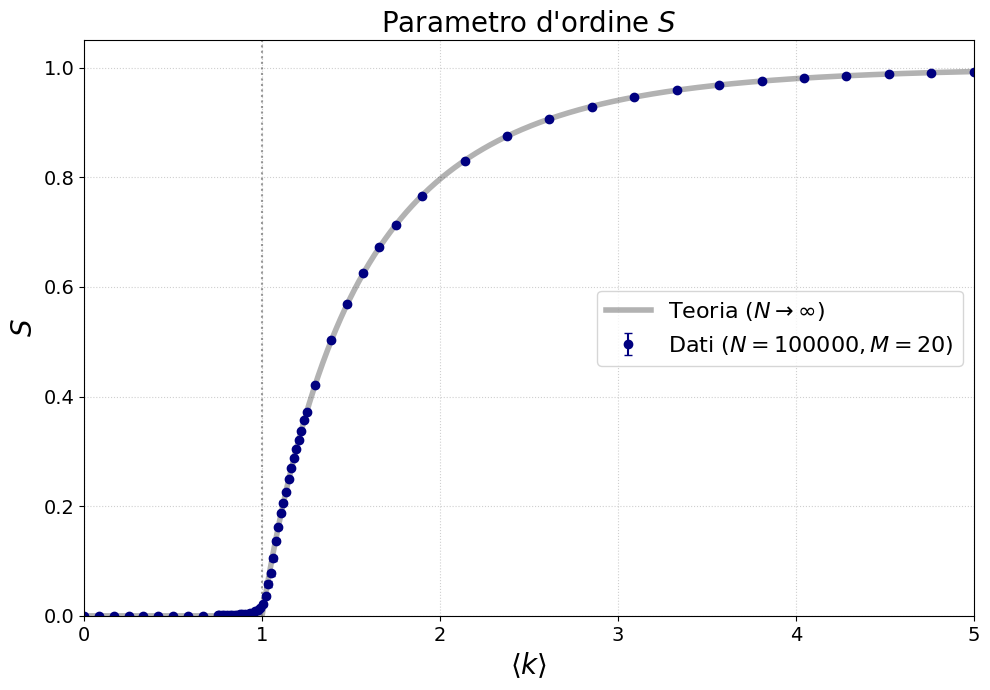

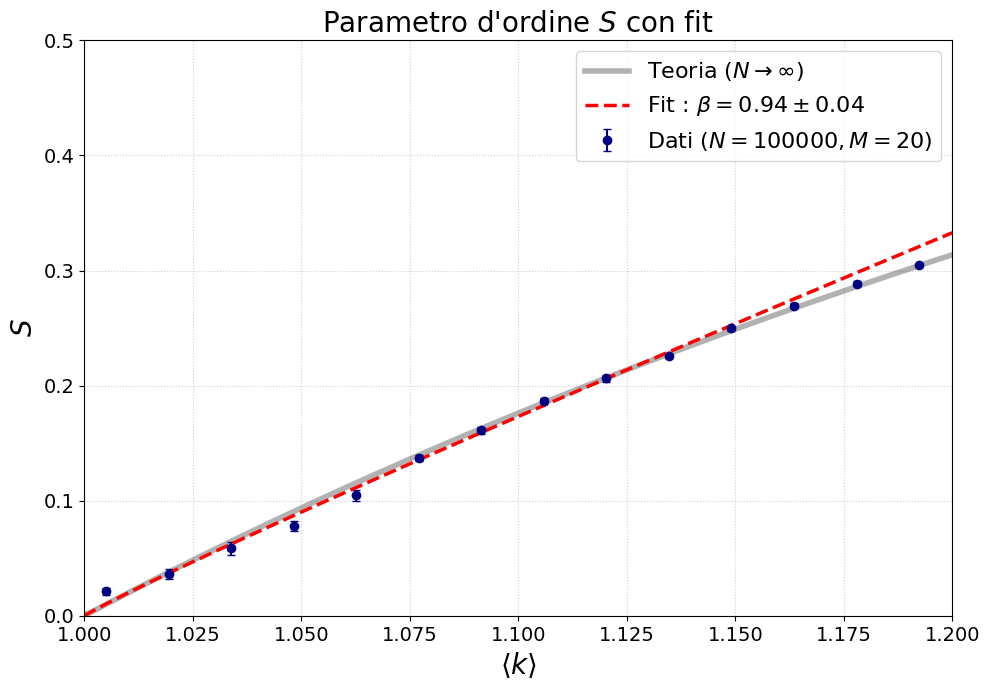

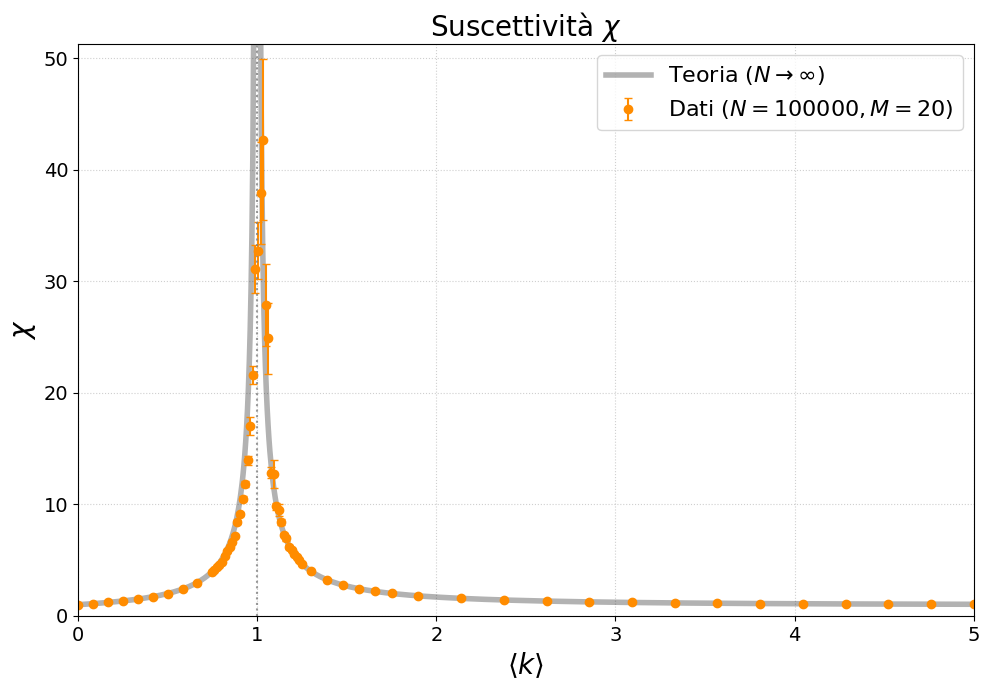

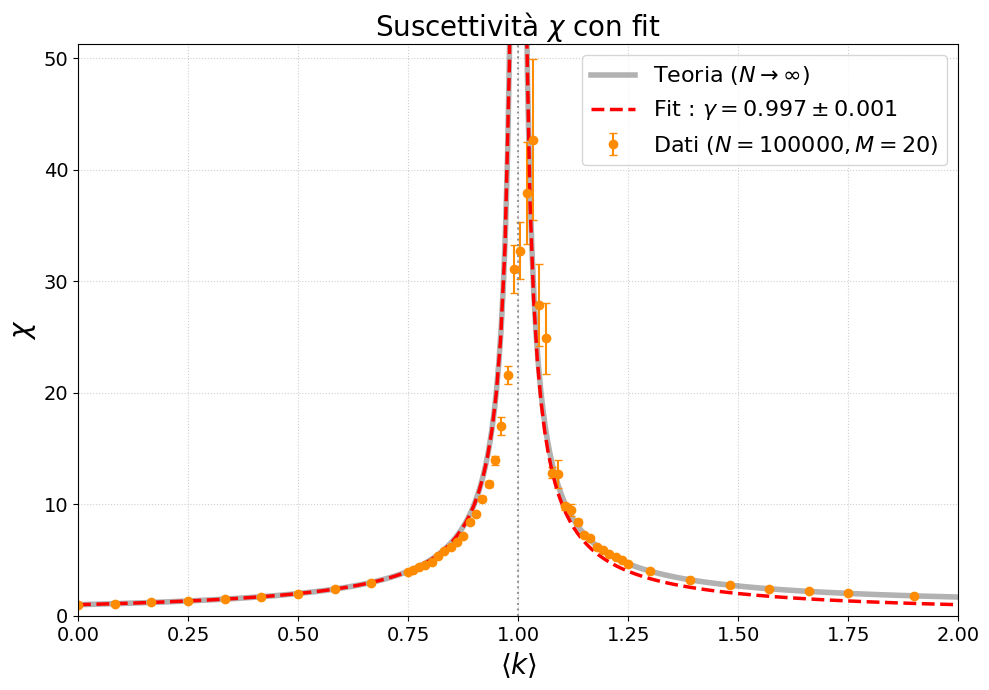

In [50]:
# --- 4. ANALISI QUANTITATIVA E GRAFICI ---
def fit_S(k, A, beta): return A * (k - 1.0)**beta
def fit_chi_symmetric(k, B, gamma): return B * np.abs(1.0 - k)**(-gamma)

# --- Stili globali grafici ---
TITLE_FS = 20
AXIS_FS = 20
TICK_FS = 14
LEGEND_FS = 16

mask_S = (k_sim > 1.0) & (k_sim < 1.1)
popt_S, pcov_S = curve_fit(fit_S, k_sim[mask_S], S_mean[mask_S],
                           sigma=S_err[mask_S], absolute_sigma=True, p0=[2.0, 1.0])
err_fit_S = np.sqrt(np.diag(pcov_S))

mask_chi_globale = ((k_sim > 0) & (k_sim < 0.95)) | ((k_sim > 1.05) & (k_sim < 2))
popt_chi, pcov_chi = curve_fit(fit_chi_symmetric, k_sim[mask_chi_globale], chi_mean[mask_chi_globale],
                               sigma=chi_err[mask_chi_globale], absolute_sigma=True, p0=[1.0, 1.0])
err_fit_chi = np.sqrt(np.diag(pcov_chi))

# --- chi-quadro ridotto ---
resid_S = (S_mean[mask_S] - fit_S(k_sim[mask_S], *popt_S)) / S_err[mask_S]
chi2_S = np.sum(resid_S**2)
ndof_S = np.count_nonzero(mask_S) - len(popt_S)
chi2_red_S = chi2_S / ndof_S if ndof_S > 0 else np.nan

resid_chi = (chi_mean[mask_chi_globale] - fit_chi_symmetric(k_sim[mask_chi_globale], *popt_chi)) / chi_err[mask_chi_globale]
chi2_chi = np.sum(resid_chi**2)
ndof_chi = np.count_nonzero(mask_chi_globale) - len(popt_chi)
chi2_red_chi = chi2_chi / ndof_chi if ndof_chi > 0 else np.nan

print("=== Risultati fit S ===")
print(f"A         = {popt_S[0]:.6f} ± {err_fit_S[0]:.6f}")
print(f"beta      = {popt_S[1]:.6f} ± {err_fit_S[1]:.6f}")
print(f"chi2 rid. = {chi2_red_S:.6f}")
print("\n=== Risultati fit chi ===")
print(f"B         = {popt_chi[0]:.10f} ± {err_fit_chi[0]:.10f}")
print(f"gamma     = {popt_chi[1]:.10f} ± {err_fit_chi[1]:.10f}")
print(f"chi2 rid. = {chi2_red_chi:.6f}")

x_max = max(np.max(k_sim), np.max(k_theory))

# --- 1. S senza fit ---
fig1, ax = plt.subplots(figsize=(10, 7))
ax.plot(k_theory, S_theory, 'k-', alpha=0.3, lw=4, label='Teoria ($N \\to \\infty$)')
ax.errorbar(k_sim, S_mean, yerr=S_err, fmt='o', c='navy', markersize=6,
            capsize=3, label=f'Dati ($N={N}, M={M}$)')
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax.set_xlim(0, x_max)
ax.set_ylim(0, 1.05)
ax.set_xlabel("$\\langle k \\rangle$", fontsize=AXIS_FS)
ax.set_ylabel("$S$", fontsize=AXIS_FS)
ax.set_title("Parametro d'ordine $S$", fontsize=TITLE_FS)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(fontsize=LEGEND_FS, loc='center right')
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=TICK_FS)
ax.tick_params(axis='y', which='both', labelleft=True, labelsize=TICK_FS)
plt.tight_layout()
plt.show()

# --- 2. S con fit (1 a 1.1) ---
fig2, ax = plt.subplots(figsize=(10, 7))
ax.plot(k_theory, S_theory, 'k-', alpha=0.3, lw=4, label='Teoria ($N \\to \\infty$)')
ax.errorbar(k_sim, S_mean, yerr=S_err, fmt='o', c='navy', markersize=6,
            capsize=3, label=f'Dati ($N={N}, M={M}$)')
k_fit_plot_S = np.linspace(1.00, 1.2, 200)
ax.plot(k_fit_plot_S, fit_S(k_fit_plot_S, *popt_S), 'r--', lw=2.5,
        label=f'Fit : $\\beta = {popt_S[1]:.2f} \\pm {err_fit_S[1]:.2f}$')
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax.set_xlim(1.0, 1.2)
ax.set_ylim(0, 0.5)
ax.set_xlabel("$\\langle k \\rangle$", fontsize=AXIS_FS)
ax.set_ylabel("$S$", fontsize=AXIS_FS)
ax.set_title("Parametro d'ordine $S$ con fit", fontsize=TITLE_FS)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(fontsize=LEGEND_FS)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=TICK_FS)
ax.tick_params(axis='y', which='both', labelleft=True, labelsize=TICK_FS)
plt.tight_layout()
plt.show()

# --- 3. chi senza fit ---
fig3, ax = plt.subplots(figsize=(10, 7))
ax.plot(k_theory, chi_theory, 'k-', alpha=0.3, lw=4, label='Teoria ($N \\to \\infty$)')
ax.errorbar(k_sim, chi_mean, yerr=chi_err, fmt='o', c='darkorange', markersize=6,
            capsize=3, label=f'Dati ($N={N}, M={M}$)')
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax.set_xlim(0, x_max)
ax.set_ylim(0, max(chi_mean) * 1.2)
ax.set_xlabel("$\\langle k \\rangle$", fontsize=AXIS_FS)
ax.set_ylabel("$\\chi$", fontsize=AXIS_FS)
ax.set_title("Suscettività $\\chi$", fontsize=TITLE_FS)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(fontsize=LEGEND_FS)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=TICK_FS)
ax.tick_params(axis='y', which='both', labelleft=True, labelsize=TICK_FS)
plt.tight_layout()
plt.show()

# --- 4. chi con fit (0 a 2) ---
fig4, ax = plt.subplots(figsize=(10, 7))
ax.plot(k_theory, chi_theory, 'k-', alpha=0.3, lw=4, label='Teoria ($N \\to \\infty$)')
ax.errorbar(k_sim, chi_mean, yerr=chi_err, fmt='o', c='darkorange', markersize=6,
            capsize=3, label=f'Dati ($N={N}, M={M}$)')
k_fit_plot_sub = np.linspace(0., 0.99, 100)
k_fit_plot_sup = np.linspace(1.01, 2, 120)
ax.plot(k_fit_plot_sub, fit_chi_symmetric(k_fit_plot_sub, *popt_chi),
        'r--', lw=2.5, label=f'Fit : $\\gamma = {popt_chi[1]:.3f} \\pm {err_fit_chi[1]:.3f}$')
ax.plot(k_fit_plot_sup, fit_chi_symmetric(k_fit_plot_sup, *popt_chi), 'r--', lw=2.5)
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax.set_xlim(0, 2.0)
ax.set_ylim(0, max(chi_mean) * 1.2)
ax.set_xlabel("$\\langle k \\rangle$", fontsize=AXIS_FS)
ax.set_ylabel("$\\chi$", fontsize=AXIS_FS)
ax.set_title("Suscettività $\\chi$ con fit", fontsize=TITLE_FS)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(fontsize=LEGEND_FS)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=TICK_FS)
ax.tick_params(axis='y', which='both', labelleft=True, labelsize=TICK_FS)
plt.tight_layout()
plt.show()